In [10]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import polars as pl
import pytomlpp as toml
import pandas as pd
from data_preprocessing import getXY, data_normalizeation
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, accuracy_score, recall_score, precision_recall_curve, average_precision_score

In [2]:
cfg = toml.load('/home/gyli/GP_HP/cfg/feature_selection.toml')
data_path = cfg['data_path']
variance_filter_thres = cfg['variance_filter_thres']
raw_x, raw_y = getXY(data_path)
future_names = raw_x.columns
X, y = raw_x.select(['年龄', '淋巴细胞数', '白蛋白', '活化部分凝血活酶时间', '低密度脂蛋白', '钠', '中性粒细胞数', '甘油三酯', '凝血酶原时间', '红细胞平均体积', '总胆红素']).to_pandas(), np.ravel(raw_y.to_pandas())

In [3]:
knn_model = KNeighborsClassifier(n_neighbors=3)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 归一化处理
    ('model', knn_model)  # 在这里更改模型
])
knn_scores = cross_val_score(pipeline, X, y, cv=5)
print("K近邻模型交叉验证结果:", knn_scores,'均值',knn_scores.mean(),'方差',knn_scores.std())

K近邻模型交叉验证结果: [0.75005031 0.60487118 0.80595813 0.77355072 0.63486312] 均值 0.7138586936267337 方差 0.07933959601975767


In [19]:
n_estimators = [i for i in range(10, 310, 10)]
# max_depth = [i for i in range(20, 12)]
min_samples_leaf = [1]
min_samples_split = [2]
max_features = [None, 'sqrt', 'log2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
scores_ = []
for n in n_estimators:
    rf_model = RandomForestClassifier(n_estimators=n, max_depth=6)
    # rf_scores = cross_val_score(rf_model, X, y, cv=5)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    scores_.append(accuracy)
#     for md in max_depth:
#         for ml in  min_samples_leaf:
#             for ms in min_samples_split:
#                 for mf in max_features:
#                     rf_model = RandomForestClassifier(n_estimators=n, max_depth=md, min_samples_leaf=ml, min_samples_split=ms, max_features=mf, random_state=42)
#                     rf_scores = cross_val_score(rf_model, X, y, cv=5)
#                     row = {'n_estimators' : n, 'max_depth' : md, 'min_samples_leaf' : ml, 'min_samples_split' : ms, 'max_features' : mf, 'mean_score' : rf_scores.mean(), 'std' : rf_scores.std()}
#                     for i, acc in enumerate(rf_scores):
#                         row[f'cross_val_score_{i+1}'] = rf_scores[i]
#                     rf_dfs.append(pd.DataFrame(row, index=[0]))
# rf_df = pd.concat(rf_dfs)
# rf_df.to_csv('/home/gyli/GP_HP/result/rf_results.csv')

In [17]:
len(scores_)

60

Text(0, 0.5, 'scores_')

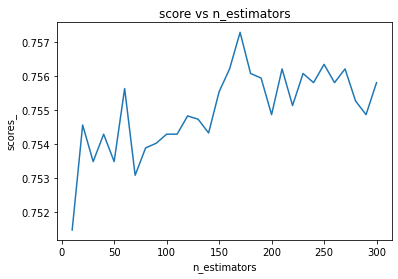

In [40]:
import matplotlib.pyplot as plt
plt.plot(n_estimators, scores_[:30])

# 添加标题和标签
plt.title('score vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('scores_')

In [39]:
for i in range(0, 12):
    scores_[i] *= 0.999

In [44]:
for i in range(10, 14):
    knn_model = KNeighborsClassifier(n_neighbors=i, p=1, weights='distance')
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # 归一化处理
        ('model', knn_model)  # 在这里更改模型
    ])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    pipeline.fit(X_train, y_train)
    y_score = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # 计算准确率和召回率
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    # recall = recall_score(y_test, y_pred)
    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_score)
    average_precision = average_precision_score(y_test, y_score)
    print('k = ', i, 'p = 1')
    print("Score:", accuracy)
    # print("Recall:", recall.mean())


k =  10 p = 1
Score: 0.8102777405071783
k =  11 p = 1
Score: 0.8167181000939219
k =  12 p = 1
Score: 0.8058499932912921
k =  13 p = 1
Score: 0.8059841674493493


In [45]:
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('model', KNeighborsClassifier(n_neighbors=13, p=1, weights='distance'))],
 'verbose': False,
 'scaler': StandardScaler(),
 'model': KNeighborsClassifier(n_neighbors=13, p=1, weights='distance'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'model__algorithm': 'auto',
 'model__leaf_size': 30,
 'model__metric': 'minkowski',
 'model__metric_params': None,
 'model__n_jobs': None,
 'model__n_neighbors': 13,
 'model__p': 1,
 'model__weights': 'distance'}